# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [1]:
#!pip install "tensorflow==1.14"

In [2]:
import sys

sys.path.extend(['frustum-pointnets-master/kitti', 'frustum-pointnets-master/models/', 'frustum-pointnets-master/train/'])

In [3]:
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER

import tensorflow as tf

def get_session_and_ops(batch_size, num_point, model, model_path):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/cpu:0'):
            (pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, 
            heading_class_label_pl, heading_residual_label_pl, 
            size_class_label_pl, size_residual_label_pl) = model.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = model.get_model(pointclouds_pl, one_hot_vec_pl, is_training_pl)
            loss = model.get_loss(labels_pl, centers_pl,
                heading_class_label_pl, heading_residual_label_pl,
                size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()
        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)
        # Restore variables from disk.
        saver.restore(sess, model_path)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops

def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape)-1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape)-1, keepdims=True)
    return probs

def inference(sess, ops, pc, one_hot_vec, batch_size, num_classes):
    ''' Run inference for frustum pointnets in batch mode '''
    assert pc.shape[0]%batch_size == 0
    num_batches = pc.shape[0]//batch_size
    logits = np.zeros((pc.shape[0], pc.shape[1], num_classes))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],)) # 3D box score 
   
    ep = ops['end_points'] 
    for i in range(num_batches):
        feed_dict = {\
            ops['pointclouds_pl']: pc[i*batch_size:(i+1)*batch_size,...],
            ops['one_hot_vec_pl']: one_hot_vec[i*batch_size:(i+1)*batch_size,:],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                ep['heading_scores'], ep['heading_residuals'],
                ep['size_scores'], ep['size_residuals']],
                feed_dict=feed_dict)

        logits[i*batch_size:(i+1)*batch_size,...] = batch_logits
        centers[i*batch_size:(i+1)*batch_size,...] = batch_centers
        heading_logits[i*batch_size:(i+1)*batch_size,...] = batch_heading_scores
        heading_residuals[i*batch_size:(i+1)*batch_size,...] = batch_heading_residuals
        size_logits[i*batch_size:(i+1)*batch_size,...] = batch_size_scores
        size_residuals[i*batch_size:(i+1)*batch_size,...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:,:,1] # BxN
        batch_seg_mask = np.argmax(batch_logits, 2) # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1) # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask,1) # B,
        heading_prob = np.max(softmax(batch_heading_scores),1) # B
        size_prob = np.max(softmax(batch_size_scores),1) # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i*batch_size:(i+1)*batch_size] = batch_scores 
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1) # B
    size_cls = np.argmax(size_logits, 1) # B
    heading_res = np.array([heading_residuals[i,heading_cls[i]] \
        for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i,size_cls[i],:] \
        for i in range(pc.shape[0])])

    return list(zip(centers, heading_cls, heading_res, size_cls, size_res))

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

In [4]:
import frustum_pointnets_v1

# Set training configurations
BATCH_SIZE = 1
MODEL_PATH = 'frustum_pointnets_snapshots/log_v1/model.ckpt'
NUM_POINT = 1024
NUM_CLASSES = 2
NUM_CHANNEL = 4

class Frustum:
    def __init__(self, batch_size=BATCH_SIZE, num_points=NUM_POINT, model_path=MODEL_PATH):
        self.session, self.ops = get_session_and_ops(batch_size, num_points, frustum_pointnets_v1, model_path)

    def predict(self, points, ohe_vectors, batch_size=BATCH_SIZE):
        return inference(self.session, self.ops, points, ohe_vectors, batch_size, NUM_CLASSES)
    
frustum = Frustum()



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators suc

In [5]:
from collections import namedtuple
import provider
import ssd

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

class PipelineDetector(object):
    def __init__(self, frustum_pointnet, ssd_detector, ssd_threshold):
        self.frustum = frustum_pointnet
        self.detector = ssd_detector
        self.ssd_thresh = ssd_threshold
    
    def predict(self, xyz, image, calibration):
        # TODO: run 2D detector on the image
        ssd_predicts = self.detector.predict(image)
        num_predictions = ssd_predicts['num_detections']
        detection_boxes = ssd_predicts['detection_boxes'][:num_predictions]
        detection_scores = ssd_predicts['detection_scores'][:num_predictions]
        detection_classes = ssd_predicts['detection_classes'][:num_predictions]
        
        cars_only = detection_classes == ssd.CAR_CLASS
        thresh_filter = detection_scores > self.ssd_thresh
        filtered = cars_only & thresh_filter
        num_predictions = sum(filtered)
        detection_boxes = detection_boxes[filtered]
        detection_scores = detection_scores[filtered]
        detection_classes = detection_classes[filtered]
        
        # Process lidar point cloud and construct frustum examples.
        height, width, _ = image.shape
        xyz_coordinates, intensities = xyz[:, :3], xyz[:, 3]
        _, _, fov_inds = kitti_object.get_lidar_in_image_fov(xyz_coordinates, calibration, 
                                                             0, 0, width, height, return_more=True)
        xy_projections = calibration.project_velo_to_image(xyz_coordinates)
        points = []
        frustum_angles = []
        for (ymin, xmin, ymax, xmax) in detection_boxes:
            xmin *= width
            xmax *= width
            ymin *= height
            ymax *= height

            x_condition = (xmin <= xy_projections[:, 0]) & (xy_projections[:, 0] <= xmax)
            y_condition = (ymin <= xy_projections[:, 1]) & (xy_projections[:, 1] <= ymax)
            filtered = xyz[x_condition & y_condition & fov_inds]

            uvdepth = np.zeros((1,3))
            uvdepth[0,0:2] = np.array([(xmin + xmax) / 2.0, (ymin + ymax) / 2.0])
            uvdepth[0,2] = 20 # some random depth
            box2d_center_rect = calibration.project_image_to_rect(uvdepth)
            frustum_angle = -1 * np.arctan2(box2d_center_rect[0,2], box2d_center_rect[0,0]) + np.pi / 2
            frustum_angles.append(frustum_angle)

            point_index = np.random.choice(len(filtered), NUM_POINT, replace=True)
            point = filtered[point_index]
            point[:, :3] = calibration.project_velo_to_ref(point[:, :3])
            point[:, :3] = provider.rotate_pc_along_y(point[:, :3], frustum_angle)
            point[:, 3] = intensities[point_index]
            points.append(point)

        # Run frustum inference (use batch to accelerate inference per frame).
        one_hot_encoding = np.hstack((np.ones((num_predictions, 1)), np.zeros((num_predictions, 2))))
        results = frustum.predict(np.array(points), one_hot_encoding)
        # Populate detections for the scene. 
        scene = Scene([])
        for result, angle, score in zip(results, frustum_angles, detection_scores):
            h, w, l, tx, ty, tz, ry = provider.from_prediction_to_label_format(
                result[0], result[1], result[2],result[3], result[4], angle
            )
            detection = Detection(xyz=np.array((tx, ty, tz)), angle=ry, lwh=np.array((l, w, h)), confidence=score)
            scene.detections.append(detection)
        return scene

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [6]:
from ssd import SSD
import pickle

detector = SSD('detector')

pipeline_detector = PipelineDetector(frustum, detector, ssd_threshold=0.0)

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [7]:
import numpy as np
import kitti_object
from matplotlib import pyplot as plt 

kitti_dataset_root = 'kitti_hw_dataset'
kitti_dataset = kitti_object.kitti_object(root_dir=kitti_dataset_root)

obj_id = 10

image = kitti_dataset.get_image(obj_id)
print('Image shape', image.shape)
xyz = kitti_dataset.get_lidar(obj_id)
print(xyz.shape)
calibration = kitti_dataset.get_calibration(obj_id)
labels = kitti_dataset.get_label_objects(obj_id)
print('labels num', len(labels))

Image shape (375, 1242, 3)
(115875, 4)
labels num 13


(-50.0, 50.0)

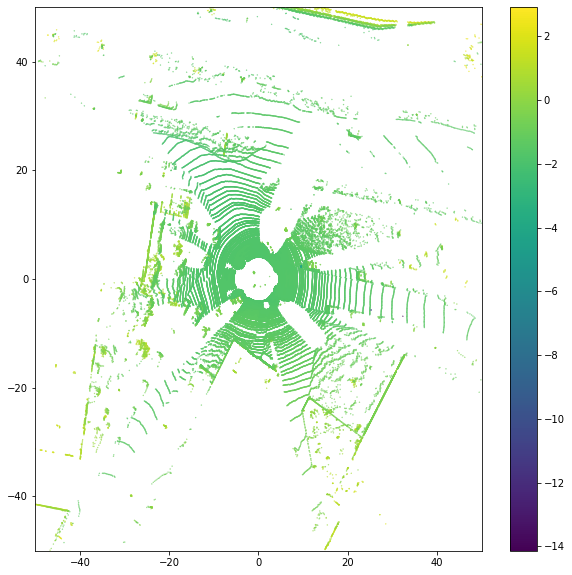

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(xyz[:, 0], xyz[:, 1], c=xyz[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

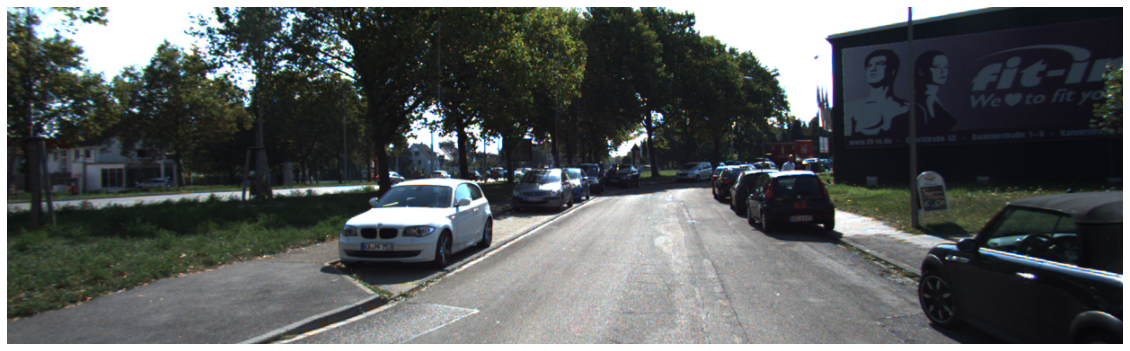

In [9]:
import cv2

plt.figure(figsize=(20, 30))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [10]:
scene = pipeline_detector.predict(xyz, image, calibration)

In [11]:
import math

def rotate_rectangle(rect, theta):
    rotated = []
    for corner in rect:
        rotated.append([
            corner[0]*math.cos(theta)-corner[1]*math.sin(theta), 
            corner[0]*math.sin(theta)+corner[1]*math.cos(theta)
        ])
    return np.array(rotated)

def get_rectangle(x, y, w, l, angle):
    initial_rect = [[-w/2, -l/2], [-w/2, l/2], [w/2, l/2], [w/2, -l/2]]
    rotated = rotate_rectangle(initial_rect, -angle)
    rotated[:, 0] += x
    rotated[:, 1] += y
    return rotated

def get_ground_truth(labels, calibration):
    ground_truth = []
    for label in labels:
        if label.type not in {'Car', 'Van'}:
            continue
        x, y, _ = calibration.project_ref_to_velo(np.expand_dims(label.t, 0))[0]
        w, l = label.w, label.l
        angle = label.ry
        ground_truth.append(get_rectangle(x, y, w, l, angle))
    return ground_truth
    
def get_detected(detections, calibration):
    detected = []
    for detection in detections:
        x, y, _ = calibration.project_ref_to_velo(np.expand_dims(detection.xyz, 0))[0]
        l, w, _ = detection.lwh
        angle = detection.angle
        detected.append(get_rectangle(x, y, w, l, angle))
    return detected

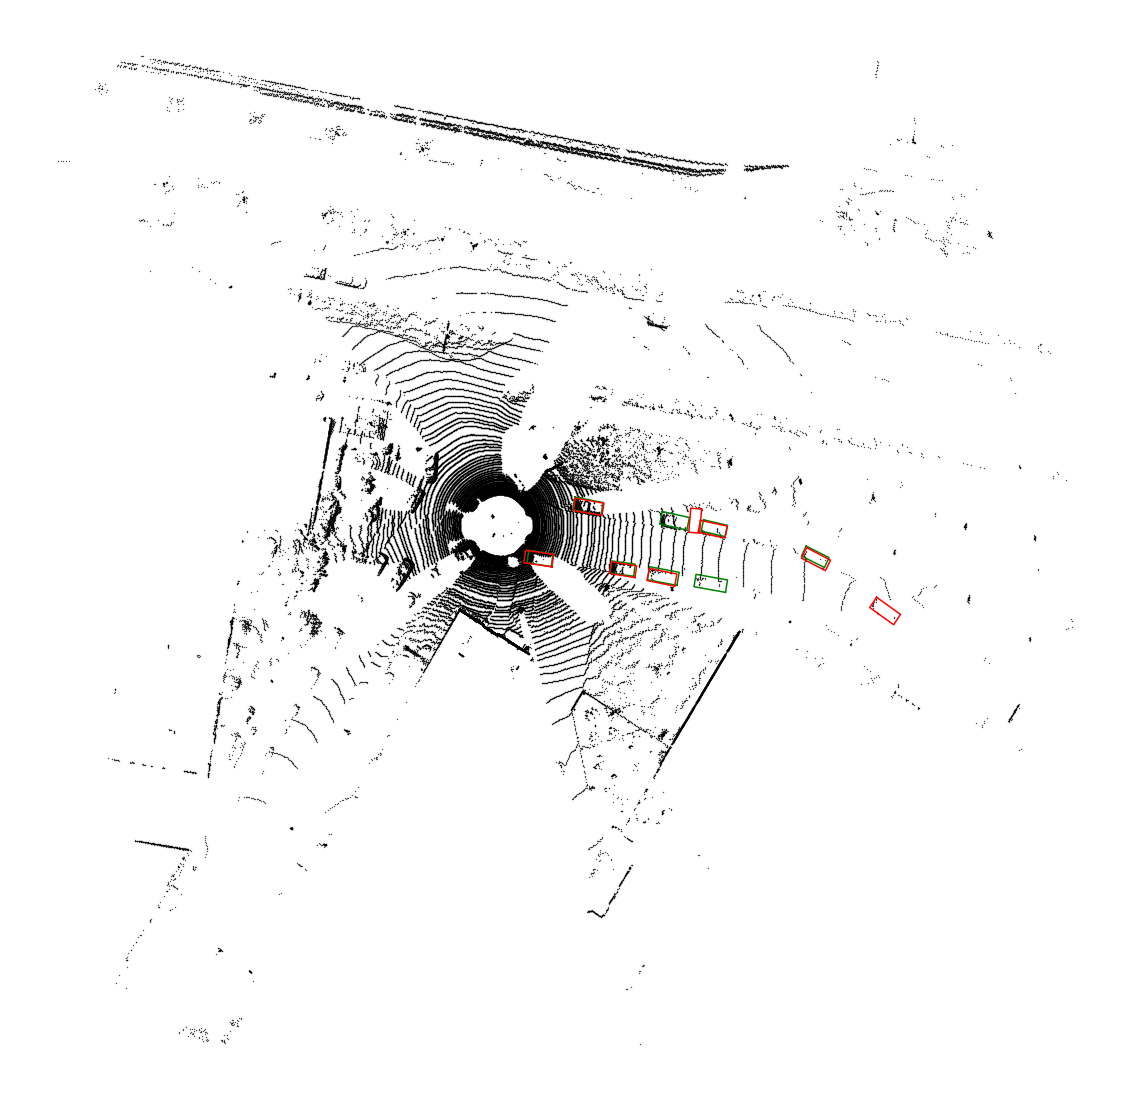

In [12]:
ground_truth = get_ground_truth(labels, calibration)
detected = get_detected(scene.detections, calibration)

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(xyz[:, 0], xyz[:, 1], c='black', s=0.1)
for gt in ground_truth:
    gt = gt.tolist()
    gt.append(gt[0])
    gt = np.array(gt)
    ax.plot(gt[:, 0], gt[:, 1], c='green')

for det in detected:
    det = det.tolist()
    det.append(det[0])
    det = np.array(det)
    ax.plot(det[:, 0], det[:, 1], c='red')

plt.axis('off')
plt.show()